In [1]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import pandas as pd
import glob
from copy import deepcopy
from scipy.stats import *
from scipy.stats.stats import pearsonr
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
# self_defined modules
from area_mean import *
from binned_cyFunctions5 import *
from read_hs_file import read_var_mod
from read_var_obs import *

from calc_LRM_metric import *
from get_LWPCMIP5data import *
from get_LWPCMIP6data import *
from get_OBSLRMdata import *
from fitLRM_cy1 import *
from fitLRM_cy2 import *
# from fitLRM_cy4 import *
from useful_func_cy import *
from calc_Radiation_LRM_1 import *
from calc_Radiation_LRM_2 import *


Test read data:

In [115]:
from calc_LRMobs_metric import *
from fitLRMobs import *
from Aploting_Sep11 import *

path1 = '/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/'
path6 = '/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/plot_file/'

In [68]:
valid_range1=[1992, 1, 15]
valid_range2=[2011, 12, 31]
valid_range3=[2012, 1, 15]
valid_range4=[2016, 12, 31]

valid_range5=[2001, 1, 15]
valid_range6=[2011, 12, 31]

valid_range7=[2012, 1, 15]
valid_range8=[2016, 12, 31]

valid_range9=[2001, 1, 15]
valid_range10=[2016, 12, 31]

# Using to do area_mean
s_range = arange(-90., 90., 5.) + 2.5  #..global-region latitude edge: (36)
x_range = arange(-180., 180., 5.)  #..logitude sequences edge: number: 72
y_range = arange(-85, -40., 5.) + 2.5  #..southern-ocaen latitude edge: 9

In [69]:
pp_path_OBS='/glade/scratch/chuyan/obs_data/'

def read_var_obs_IMERG3(valid_range1 = [2002, 7, 15], valid_range2 = [2016, 12, 31], data_type = '2'):
    #------------------
    # This function is for reading IMERG precipitation observation (HDF5).
    # valid_range1 & 2: the starting and end time stamps of time sequential metric. Only the first two values are valid for monthly data.
    # data_type: there are two types of IMERG data, '1': raw resolution (0.1 X 0.1, -180 ~ 180, -90 ~ 90)
    # '2': regrided resolution (1 X 1, 0.5 ~ 359.5, 89.5 ~ -89.5)
    #------------------
    # 'read_hs' functionality:

    folder = pp_path_OBS
    data_type ='2'

    if data_type == '2':
        # file_name example: '3B-MO.MS.MRG.3IMERG.20161201-S000000-E235959.12.V06B.HDF5.SUB.nc4'

        fn = glob.glob(folder + '*'+ '3B-MO.MS.MRG.3IMERG.' + '*' + '.V06B.HDF5.SUB.nc4')
        # print(fn)

    # 'read_hs_file' functionality:

    # loading the data files one by one through 'netCDF4' module, but in a random order of times
    data = []
    timeo = []
    varnm = 'precipitation'
    for i in range(len(fn)):

        file = nc.Dataset(fn[i], 'r')  # random order of times (due to the functionality of "glob")

        tt = np.asarray(file.variables['time'])  # Time (Monthly data)
        lat = np.asarray(file.variables['lat'])  # Latitude
        lon = np.asarray(file.variables['lon'])  # Longitude

        # Create a shape = (n, 3) array to store the (year, mon, day) cf.datetime object:
        time_i = np.zeros((len(tt), 3))

        for i in range(len(tt)):

            tt1 = nc.num2date(tt[i], file.variables['time'].units, calendar = u'standard')  # cf.Datetime object: including yr, mon, day, hour, minute, second info

            time_i[i,:] = [tt1.year, tt1.month, tt1.day]

        # Precipitation data:

        data_pieces = []

        # determine whether the variable_time within the time_range we want:
        if valid_range1[0] != valid_range2[0]:   # case 1, starting time and ending time are the different year.
            if ((time_i[0, 0] > valid_range1[0]) & (time_i[0, 0] < valid_range2[0])) | ((time_i[0, 0] == valid_range1[0]) & (time_i[0, 1] >= valid_range1[1])) | ((time_i[0, 0] == valid_range2[0]) & (time_i[0, 1] <= valid_range2[1])):

                data_pieces = file.variables[varnm]   # data, in unit of mm/hr

        elif (valid_range1[0] == valid_range2[0]) & (time_i[0, 0] == valid_range2[0]):   # case 2, starting and ending time are the same year.
            if  (time_i[0, 1] >= valid_range1[1]) & (time_i[0, 1] <= valid_range2[1]):

                data_pieces = file.variables[varnm]   # data, in unit of mm/hr        
        # print(data_pieces)

        # end 'read_hs_file' functionality.

        if len(data_pieces) > 0:
                data.append(data_pieces)  # Variable
                timeo.append(time_i)  # Times

    # ending loop, and end 'read_hs' functionality.

    # 'read_var_mod' functionality

    # processing lat, lon, data, and time array, output in an ordered arrangement

    # use 'np.concatenate' to get rid of one extra axis (the second axes)
    dataOUT = np.concatenate(data, axis = 0)
    timeOUT = np.concatenate(timeo, axis = 0)
    # print(np.asarray(dataOUT).shape)

    if len(dataOUT) == 0:
        print(" No data in the desired time period. ")

    # replacing fill value to be 'np.nan'
    dataOUT = np.asarray(dataOUT)
    dataOUT[dataOUT == file.variables[varnm]._FillValue] = np.nan

    # print(dataOUT)

    # use 'np.unique' to get ordered time and data array
    tf = timeOUT[:, 0] + timeOUT[:, 1]/100.
    TF, ind = np.unique(tf, return_index = True)  # TF is the sorted (time from smaller value to bigger value), unique 'tf', and ind is the indices

    dataOUT = dataOUT[ind]
    dataOUT = dataOUT.reshape(len(tf), len(lat), len(lon))
    timeOUT = timeOUT[ind]

    if data_type == '2':

        # print(lat)  # Originally is from -90. to 90.
        lat1 = lat[::-1] *1.
        # print(lon)  # Originally is from -180. to 180.
        lon2 = lon[:] *1.
        lon2[lon2 > 180] = lon2[lon2 > 180] - 360.  # convert to range from -180. to 180.
        ind_sort = np.argsort(lon2)
        lon2 = lon2[ind_sort]
        # print(ind_sort)
        dataOUT1 = dataOUT.copy()
        if np.argsort(lat)[0] != 0:
            lat = lat1
            dataOUT1 = dataOUT1[:, ::-1, ind_sort]

        dataOUT = dataOUT1

    return np.asarray(dataOUT), np.asarray(lat), np.asarray(lon2), np.asarray(timeOUT)


In [95]:
# Re-calculate annual mean variability:

P_IMERG3, lat_IMERG3, lon_IMERG3, times_IMERG3 = read_var_obs_IMERG3(valid_range1=valid_range9, valid_range2=valid_range10, data_type='2')

E, lat_merra2, lon_merra2, Pres, times_merra2 = read_var_obs_MERRA2(varnm = 'EFLUX', read_p = False, valid_range1=valid_range9, valid_range2=valid_range10, data_type='2')

SST = read_var_obs_MERRA2(varnm = 'TS', read_p = False, valid_range1=valid_range9, valid_range2=valid_range10, data_type='2')[0]

LWP, lwp_error, mask_array_mac, lat_mac, lon_mac, times_mac = read_var_obs_MAClwp(varnm = 'cloudlwp', valid_range1 = valid_range9, valid_range2 = valid_range10)
# print(P_IMERG3.shape)
# print(E.shape)

# Eva: Evaporation, Unit in mm day^-1 (here use the latent heat flux from the sfc, unit convert from W m^-2 --> kg m^-2 s^-1 --> mm day^-1)
lh_vaporization = (2.501 - (2.361 * 10**-3) * (SST - 273.15)) * 1e6  # the latent heat of vaporization at the surface Temperature
Eva = E / lh_vaporization * (24. * 60 * 60)

Precip = (P_IMERG3 * 24.)

# Moisture convergence:
MC_IMERG3 = Precip - Eva

MC_so, lats_so, lons_so = region_cropping_var(MC_IMERG3, lat_IMERG3, lon_IMERG3, lat_range = [-85., -40.], lon_range = [-180., 180.])
LWP_so, lats_so_mac, lons_so_mac = region_cropping_var(LWP, lat_mac, lon_mac, lat_range = [-85., -40.], lon_range = [-180., 180.])

# calcuate annual mean MC:
MC_SO_an = annually_mean(MC_so, times_IMERG3, label = 'mon')
LWP_SO_an = annually_mean(LWP_so, times_mac, label = 'mon')
# print(MC_SO_an.shape)

# propagate NaN value:

test_array_yr = np.ones((LWP_SO_an.shape))

test_array_yr = MC_SO_an * test_array_yr * LWP_SO_an

shape_ratio_yr = np.asarray(np.nonzero(np.isnan(test_array_yr) == True)).shape[1] / len(test_array_yr.flatten())
print(shape_ratio_yr)
ind_NaN = np.isnan(test_array_yr)  # store the mask positions for annually mean MERRA-2, MAC-LWP, CERES data in the SO;

x_array_yr = np.zeros((LWP_SO_an.shape))  # used for count the missing points in annually mean binned boxes
x_array_yr[ind_NaN] = 1.0

# Propagating the .nan into annually mean data:
MC_SO_an_nan = deepcopy(MC_SO_an)
LWP_SO_an_nan = deepcopy(LWP_SO_an)
MC_SO_an_nan[ind_NaN] = np.nan
LWP_SO_an_nan[ind_NaN] = np.nan


# calculate the SO 5 x 5^{o} bin:
MC_SO_an_bin_nan = binned_cySouthOcean5(MC_SO_an_nan, lats_so, lons_so)
LWP_SO_an_bin_nan = binned_cySouthOcean5(LWP_SO_an_nan, lats_so_mac, lons_so_mac)
print(MC_SO_an_bin_nan.shape)
print(LWP_SO_an_bin_nan.shape)
# since the latitide/ longitude grid for MERRA-2 (data_type = '2') and MAC-LWP/ CERES-EBAF-TOA_Ed4.1 are the same, it does not matter for the choice of lat/lon.


# count the ratio of values that are missing in each bin boxes:
ratio_array = binned_cySO_availabledata(x_array_yr, lats_so, lons_so)

ind_binned_omit = np.where(ratio_array> 0.50, True, False)  # ignoring bin boxes which has the ratio of np.nan points over 0.5.

shape_ratio_bin = np.asarray(np.nonzero(ind_binned_omit == True)).shape[1] / len(ind_binned_omit.flatten())
print(shape_ratio_bin)   # ratio of bin boxes that should be omited

MC_SO_an_bin_nan[ind_binned_omit] = np.nan
LWP_SO_an_bin_nan[ind_binned_omit] = np.nan




# print(lat_IMERG3, lon_IMERG3)

(0,)
(0,)
[2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015 2016]
0.5070563271604939
(16, 9, 72)
(16, 9, 72)
0.511670524691358


In [6]:
def get_OBSLRM(valid_range1=[2002, 7, 15], valid_range2=[2016, 12, 31]):
    # This function is for reading the observation data from the MERRA-2 Re-analysis, .. for LRM training and testing.
    
    T_alevs, lat_merra2, lon_merra2, Pres, times_merra2 = read_var_obs_MERRA2(varnm = 'T', read_p = True, valid_range1=valid_range1, valid_range2=valid_range2, data_type = '2')
    T_700 = T_alevs[:, 12, :,:]  # 700 hPa level
    
    sub = read_var_obs_MERRA2(varnm = 'OMEGA500', read_p = False, valid_range1=valid_range1, valid_range2=valid_range2, data_type='2')[0]
    sfc_T = read_var_obs_MERRA2(varnm = 'TS', read_p = False, valid_range1=valid_range1, valid_range2=valid_range2, data_type='2')[0]
    sfc_P = read_var_obs_MERRA2(varnm = 'PS', read_p = False, valid_range1=valid_range1, valid_range2=valid_range2, data_type='2')[0]
    tas = read_var_obs_MERRA2(varnm = 'T2M', read_p = False, valid_range1=valid_range1, valid_range2=valid_range2, data_type ='2')[0]
    P = read_var_obs_MERRA2(varnm = 'PRECTOT', read_p = False, valid_range1=valid_range1, valid_range2=valid_range2, data_type='2')[0]
    P_IMERG3, lat_imerg, lon_imerg, times_imerg = read_var_obs_IMERG3(valid_range1=valid_range1, valid_range2=valid_range2, data_type='2')
    
    E = read_var_obs_MERRA2(varnm = 'EFLUX', read_p = False, valid_range1=valid_range1, valid_range2=valid_range2, data_type='2')[0]
    
    lwp, lwp_error, mask_array_mac, lat_mac, lon_mac, times_mac = read_var_obs_MAClwp(varnm = 'cloudlwp', valid_range1 = valid_range1, valid_range2 = valid_range2)
    
    rsut, lat_ceres, lon_ceres, times_ceres = read_var_obs_CERES(varnm = 'toa_sw_all_mon', valid_range1=valid_range1, valid_range2=valid_range2)
    rsdt = read_var_obs_CERES(varnm = 'solar_mon', valid_range1=valid_range1, valid_range2=valid_range2)[0]
    rsutcs = read_var_obs_CERES(varnm = 'toa_sw_clr_c_mon', valid_range1=valid_range1, valid_range2=valid_range2)[0]
    
    inputVar_obs = {'sfc_T': sfc_T, 'T_700': T_700, 'sfc_P': sfc_P, 'sub': sub, 'tas': tas, 'lwp': lwp, 'lwp_error': lwp_error, 'P': P, 'P_IMERG': P_IMERG3, 'E': E, 'rsdt': rsdt, 'rsut': rsut, 'rsutcs': rsutcs, 'pres': Pres, 'lat_merra2': lat_merra2, 'lon_merra2': lon_merra2, 'times_merra2': times_merra2, 'times_imerg': times_imerg, 'maskarray_mac': mask_array_mac, 'lat_mac': lat_mac, 'lon_mac': lon_mac, 'times_mac': times_mac, 'lat_ceres': lat_ceres, 'lon_ceres': lon_ceres, 'times_ceres': times_ceres}
    
    return inputVar_obs

In [50]:
def Pre_processing_IMERG3(s_range, x_range, y_range, valid_range1=[2002, 7, 15], valid_range2=[2016, 12, 31]):
    # get the variables for training:
    inputVar_obs = get_OBSLRM(valid_range1=valid_range1, valid_range2=valid_range2)
    # ------------------------
    # radiation code
    
    # Data processing
    # Liquid water path, Unit in kg m^-2
    LWP = inputVar_obs['lwp'] / 1000.
    # 1-Sigma Liquid water path statistic error, Unit in kg m^-2
    LWP_error = inputVar_obs['lwp_error'] / 1000.
    # the MaskedArray of 'MAC-LWP' dataset
    Maskarray_mac = inputVar_obs['maskarray_mac']


    # GMT: Global mean surface air Temperature (2-meter), Unit in K
    gmt = inputVar_obs['tas'] * 1.
    # X_{i}: CCFs:
    # T_s: Sea Surface Temperature or skin- Temperature, Unit in K
    SST = inputVar_obs['sfc_T'] * 1.

    # Eva: Evaporation, Unit in mm day^-1 (here use the latent heat flux from the sfc, unit convert from W m^-2 --> kg m^-2 s^-1 --> mm day^-1)
    lh_vaporization = (2.501 - (2.361 * 10**-3) * (SST - 273.15)) * 1e6  # the latent heat of vaporization at the surface Temperature
    Eva = inputVar_obs['E'] / lh_vaporization * (24. * 60 * 60)

    # Precip: Precipitation, Unit in mm day^-1 (convert from kg m^-2 s^-1)

    Precip = inputVar_obs['P'] * (24. * 60 * 60)

    # Precipitation data 2 from IMERG, Unit in mm/day (convert from mm/hr)

    Precip_IMERG = inputVar_obs['P_IMERG'] * (24.)

    # MC: Moisture Convergence, represent the water vapor abundance, Unit in mm day^-1

    MC = Precip - Eva  # FROM 2011 TO 2016

    MC_IMERG = Precip_IMERG - Eva[len(Eva)-len(Precip_IMERG)::, :, :]  # FROM 2011 TO 2016;

    # print(MC_IMERG)

    # LTS: Lower Tropospheric Stability, Unit in K (the same as Potential Temperature):
    k = 0.286

    theta_700 = inputVar_obs['T_700'] * (100000. / 70000.)**k
    theta_skin = inputVar_obs['sfc_T'] * (100000. / inputVar_obs['sfc_P'])**k
    LTS_m = theta_700 - theta_skin  # LTS with np.nan

    # #.. mask the place with np.nan value
    # LTS_e = np.ma.masked_where(theta_700==np.nan, LTS_m)
    # # print(LTS_e)

    # 500 mb Subsidence:
    Subsidence = inputVar_obs['sub']

    # SW radiative fluxes:
    Rsdt = inputVar_obs['rsdt']
    Rsut = inputVar_obs['rsut']
    Rsutcs = inputVar_obs['rsutcs']

    albedo = Rsut / Rsdt
    albedo_cs = Rsutcs / Rsdt
    Alpha_cre = albedo - albedo_cs
    # abnormal values:
    albedo_cs[(albedo_cs <= 0.08) & (albedo_cs >= 1.00)] == np.nan
    Alpha_cre[(albedo_cs <= 0.08) & (albedo_cs >= 1.00)] == np.nan

    # define Dictionary to store: CCFs(4), gmt, other variables :
    dict0_var = {'gmt': gmt, 'SST': SST, 'p_e': MC, 'p_e_IMERG': MC_IMERG, 'LTS': LTS_m, 'SUB': Subsidence, 'LWP': LWP, 'rsdt': Rsdt, 'rsut': Rsut, 'rsutcs': Rsutcs, 'albedo' : albedo, 'albedo_cs': albedo_cs, 'alpha_cre': Alpha_cre, 'LWP_statistic_error': LWP_error, 'Maskarray_mac': Maskarray_mac}
    
    
    # Crop the regions
    # crop the variables to the Southern Ocean latitude range: (40 ~ 85^o S)

    dict1_SO, lat_merra2_so, lon_merra2_so = region_cropping(dict0_var, ['SST', 'p_e', 'p_e_IMERG', 'LTS', 'SUB'], inputVar_obs['lat_merra2'], inputVar_obs['lon_merra2'], lat_range = [-85., -40.], lon_range = [-180., 180.])
    dict1_SO, lat_mac_so, lon_mac_so = region_cropping(dict1_SO, ['LWP', 'LWP_statistic_error', 'Maskarray_mac'], inputVar_obs['lat_mac'], inputVar_obs['lon_mac'], lat_range =[-85., -40.], lon_range = [-180., 180.])

    # print(dict1_SO['p_e'])
    # print(dict1_SO['p_e_IMERG'])

    # Time-scale average
    # monthly mean (not changed)
    dict2_SO_mon = deepcopy(dict1_SO)


    # annual mean variable
    dict2_SO_yr = get_annually_dict(dict1_SO, ['gmt', 'SST', 'p_e', 'p_e_IMERG', 'LTS', 'SUB', 'LWP', 'LWP_statistic_error', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'alpha_cre'], inputVar_obs['times_merra2'], label = 'mon')

    # print(dict2_SO_yr['SST'].shape, area_mean(dict2_SO_yr['p_e_IMERG'], lat_merra2_so, lon_merra2_so), area_mean(dict2_SO_yr['p_e'], lat_merra2_so, lon_merra2_so))

    # Propagate the np.nan values in 3 different datasets:
    # monthly data
    test_array_mon = np.ones((dict2_SO_mon['LWP'].shape))
    for i in ['SST', 'p_e', 'p_e_IMERG', 'LTS', 'SUB', 'LWP', 'LWP_statistic_error', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'alpha_cre']:
        if dict2_SO_mon[i].shape == dict2_SO_mon['LWP'].shape:
            test_array_mon = test_array_mon * (1. * dict2_SO_mon[i])

    shape_ratio_mon = np.asarray(np.nonzero(np.isnan(test_array_mon) == True)).shape[1] / len(test_array_mon.flatten())

    Maskarray_all_mon = np.isnan(test_array_mon)  # store the mask positions for monthly MERRA-2, MAC-LWP, CERES data in the SO;

    x_array_mon = np.zeros((dict2_SO_mon['SST'].shape))  # used for count the missing points in monthly binned boxes
    x_array_mon[np.isnan(test_array_mon)] = 1.0

    # print(shape_ratio_mon, x_array_mon)

    # Propagating the .nan into monthly mean data:
    for j in ['SST', 'p_e', 'p_e_IMERG', 'LTS', 'SUB', 'LWP', 'LWP_statistic_error', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'alpha_cre']:
        if dict2_SO_mon[j].shape == dict2_SO_mon['LWP'].shape:
            dict2_SO_mon[j][Maskarray_all_mon] = np.nan


    # annually data
    test_array_yr = np.ones((dict2_SO_yr['LWP'].shape))
    for i in ['SST', 'p_e', 'p_e_IMERG', 'LTS', 'SUB', 'LWP', 'LWP_statistic_error', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'alpha_cre']:
            if dict2_SO_yr[i].shape == dict2_SO_yr['LWP'].shape:
                test_array_yr = test_array_yr * (1. * dict2_SO_yr[i])

    shape_ratio_yr = np.asarray(np.nonzero(np.isnan(test_array_yr) == True)).shape[1] / len(test_array_yr.flatten())
    # print(shape_ratio_yr)
    Maskarray_all_yr = np.isnan(test_array_yr)  # store the mask positions for annually mean MERRA-2, MAC-LWP, CERES data in the SO;

    x_array_yr = np.zeros((dict2_SO_yr['SST'].shape))  # used for count the missing points in annually mean binned boxes
    x_array_yr[np.isnan(test_array_yr)] = 1.0

    # Propagating the .nan into annually mean data:
    for j in ['SST', 'p_e', 'p_e_IMERG', 'LTS', 'SUB', 'LWP', 'LWP_statistic_error', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'alpha_cre']:
        if dict2_SO_yr[j].shape == dict2_SO_yr['LWP'].shape:
            dict2_SO_yr[j][Maskarray_all_yr] = np.nan



    # binned (spatial) avergae.
    # Southern Ocean 5 * 5 degree bin box
    #..set are-mean range and define function
    s_range = arange(-90., 90., 5.) + 2.5  #..global-region latitude edge: (36)
    x_range = arange(-180., 180.5, 5.)  #..logitude sequences edge: number: 72
    y_range = arange(-85, -40., 5.) + 2.5  #..southern-ocaen latitude edge: 9


    # binned Monthly variables:
    dict3_SO_mon_bin = {}

    for e in ['SST', 'p_e', 'p_e_IMERG', 'LTS', 'SUB', 'LWP', 'LWP_statistic_error', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'alpha_cre']:

        dict3_SO_mon_bin[e] = binned_cySouthOcean5(dict2_SO_mon[e], inputVar_obs['lat_ceres'], inputVar_obs['lon_ceres'])
        # since the latitide/ longitude grid for MERRA-2 (data_type = '2') and MAC-LWP/ CERES-EBAF-TOA_Ed4.1 are the same, it does not matter for the choice of lat/lon.

    dict3_SO_mon_bin['gmt'] = binned_cyGlobal5(dict2_SO_mon['gmt'], inputVar_obs['lat_merra2'], inputVar_obs['lon_merra2'])
    print("End monthly data binned.")

    # binned Annually data (it's different than do the binned operation on the 'dict2_SO_yr'):
    dict3_SO_yr_bin = get_annually_dict(dict3_SO_mon_bin, ['gmt', 'SST', 'p_e', 'p_e_IMERG', 'LTS', 'SUB', 'LWP', 'LWP_statistic_error', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'alpha_cre'], inputVar_obs['times_merra2'])

    print("End annually data binned.")


    # count the ratio of values that are missing in each bin boxes:
    ratio_array = binned_cySO_availabledata(x_array_mon, inputVar_obs['lat_ceres'], inputVar_obs['lon_ceres'])

    ind_binned_omit = np.where(ratio_array>0.499, True, False)  # ignoring bin boxes which has the ratio of np.nan points over 0.5.

    shape_ratio_bin = np.asarray(np.nonzero(ind_binned_omit == True)).shape[1] / len(ind_binned_omit.flatten())
    # print(shape_ratio_bin)   # ratio of bin boxes that should be omited

    for k in ['SST', 'p_e', 'p_e_IMERG', 'LTS', 'SUB', 'LWP', 'LWP_statistic_error', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'alpha_cre']:
        if dict3_SO_mon_bin[k].shape == dict3_SO_mon_bin['LWP'].shape:
            dict3_SO_mon_bin[k][ind_binned_omit] = np.nan


    
    return dict3_SO_mon_bin, np.asarray(lat_merra2_so), np.asarray(lon_merra2_so), np.asarray(inputVar_obs['times_merra2'])

In [8]:
# This function is for reading the observation data from the MERRA-2 Re-analysis, .. for LRM training and testing.

T_alevs, lat_merra2, lon_merra2, Pres, times_merra2 = read_var_obs_MERRA2(varnm = 'T', read_p = True, valid_range1=valid_range3, valid_range2=valid_range4, data_type = '2')
T_700 = T_alevs[:, 12, :,:]  # 700 hPa level

sub = read_var_obs_MERRA2(varnm = 'OMEGA500', read_p = False, valid_range1=valid_range3, valid_range2=valid_range4, data_type='2')[0]
sfc_T = read_var_obs_MERRA2(varnm = 'TS', read_p = False, valid_range1=valid_range3, valid_range2=valid_range4, data_type='2')[0]
sfc_P = read_var_obs_MERRA2(varnm = 'PS', read_p = False, valid_range1=valid_range3, valid_range2=valid_range4, data_type='2')[0]
tas = read_var_obs_MERRA2(varnm = 'T2M', read_p = False, valid_range1=valid_range3, valid_range2=valid_range4, data_type ='2')[0]

P = read_var_obs_MERRA2(varnm = 'PRECTOT', read_p = False, valid_range1=valid_range3, valid_range2=valid_range4, data_type='2')[0]
P_IMERG3, lat_imerg, lon_imerg, times_imerg = read_var_obs_IMERG3(valid_range1=valid_range7, valid_range2=valid_range8, data_type='2')

E = read_var_obs_MERRA2(varnm = 'EFLUX', read_p = False, valid_range1=valid_range3, valid_range2=valid_range4, data_type='2')[0]

lwp, lwp_error, mask_array_mac, lat_mac, lon_mac, times_mac = read_var_obs_MAClwp(varnm = 'cloudlwp', valid_range1 = valid_range3, valid_range2 = valid_range4)

rsut, lat_ceres, lon_ceres, times_ceres = read_var_obs_CERES(varnm = 'toa_sw_all_mon', valid_range1=valid_range3, valid_range2=valid_range4)
rsdt = read_var_obs_CERES(varnm = 'solar_mon', valid_range1=valid_range3, valid_range2=valid_range4)[0]
rsutcs = read_var_obs_CERES(varnm = 'toa_sw_clr_c_mon', valid_range1=valid_range3, valid_range2=valid_range4)[0]

inputVar_obs = {'sfc_T': sfc_T, 'T_700': T_700, 'sfc_P': sfc_P, 'sub': sub, 'tas': tas, 'lwp': lwp, 'lwp_error': lwp_error, 'P': P, 'P_IMERG': P_IMERG3, 'E': E, 'rsdt': rsdt, 'rsut': rsut, 'rsutcs': rsutcs, 'pres': Pres, 'lat_merra2': lat_merra2, 'lon_merra2': lon_merra2, 'times_merra2': times_merra2, 'times_imerg': times_imerg, 'maskarray_mac': mask_array_mac, 'lat_mac': lat_mac, 'lon_mac': lon_mac, 'times_mac': times_mac, 'lat_ceres': lat_ceres, 'lon_ceres': lon_ceres, 'times_ceres': times_ceres}

(42,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
[2012 2013 2014 2015 2016]


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  return array(a, dtype, copy=False, order=order)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  return array(a, dtype, copy=False, order=order)


Fill Value:  -999.0
(60, 45, 360)
Fill Value:  -999.0
(60, 45, 360)
Fill Value:  -999.0
(60, 45, 360)


In [9]:
# Data processing
# Liquid water path, Unit in kg m^-2
LWP = inputVar_obs['lwp'] / 1000.
# 1-Sigma Liquid water path statistic error, Unit in kg m^-2
LWP_error = inputVar_obs['lwp_error'] / 1000.
# the MaskedArray of 'MAC-LWP' dataset
Maskarray_mac = inputVar_obs['maskarray_mac']


# GMT: Global mean surface air Temperature (2-meter), Unit in K
gmt = inputVar_obs['tas'] * 1.
# X_{i}: CCFs:
# T_s: Sea Surface Temperature or skin- Temperature, Unit in K
SST = inputVar_obs['sfc_T'] * 1.

# Eva: Evaporation, Unit in mm day^-1 (here use the latent heat flux from the sfc, unit convert from W m^-2 --> kg m^-2 s^-1 --> mm day^-1)
lh_vaporization = (2.501 - (2.361 * 10**-3) * (SST - 273.15)) * 1e6  # the latent heat of vaporization at the surface Temperature
Eva = inputVar_obs['E'] / lh_vaporization * (24. * 60 * 60)

# Precip: Precipitation, Unit in mm day^-1 (convert from kg m^-2 s^-1)

Precip = inputVar_obs['P'] * (24. * 60 * 60)

# Precipitation data 2 from IMERG, Unit in mm/day (convert from mm/hr)

Precip_IMERG = inputVar_obs['P_IMERG'] * (24.)

# MC: Moisture Convergence, represent the water vapor abundance, Unit in mm day^-1

MC = Precip - Eva  # FROM 2011 TO 2016

MC_IMERG = Precip_IMERG - Eva[len(Eva)-len(Precip_IMERG)::, :, :]  # FROM 2011 TO 2016;

# print(MC_IMERG)

# LTS: Lower Tropospheric Stability, Unit in K (the same as Potential Temperature):
k = 0.286

theta_700 = inputVar_obs['T_700'] * (100000. / 70000.)**k
theta_skin = inputVar_obs['sfc_T'] * (100000. / inputVar_obs['sfc_P'])**k
LTS_m = theta_700 - theta_skin  # LTS with np.nan

# #.. mask the place with np.nan value
# LTS_e = np.ma.masked_where(theta_700==np.nan, LTS_m)
# # print(LTS_e)

# 500 mb Subsidence:
Subsidence = inputVar_obs['sub']

# SW radiative fluxes:
Rsdt = inputVar_obs['rsdt']
Rsut = inputVar_obs['rsut']
Rsutcs = inputVar_obs['rsutcs']

albedo = Rsut / Rsdt
albedo_cs = Rsutcs / Rsdt
Alpha_cre = albedo - albedo_cs
# abnormal values:
albedo_cs[(albedo_cs <= 0.08) & (albedo_cs >= 1.00)] == np.nan
Alpha_cre[(albedo_cs <= 0.08) & (albedo_cs >= 1.00)] == np.nan

# define Dictionary to store: CCFs(4), gmt, other variables :
dict0_var = {'gmt': gmt, 'SST': SST, 'p_e': MC, 'p_e_IMERG': MC_IMERG, 'LTS': LTS_m, 'SUB': Subsidence, 'LWP': LWP, 'rsdt': Rsdt, 'rsut': Rsut, 'rsutcs': Rsutcs, 'albedo' : albedo, 'albedo_cs': albedo_cs, 'alpha_cre': Alpha_cre, 'LWP_statistic_error': LWP_error, 'Maskarray_mac': Maskarray_mac}

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in less_equal
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater_equal
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in less_equal
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in greater_equal


In [10]:


# Crop the regions
# crop the variables to the Southern Ocean latitude range: (40 ~ 85^o S)

dict1_SO, lat_merra2_so, lon_merra2_so = region_cropping(dict0_var, ['SST', 'p_e', 'p_e_IMERG', 'LTS', 'SUB'], inputVar_obs['lat_merra2'], inputVar_obs['lon_merra2'], lat_range = [-85., -40.], lon_range = [-180., 180.])
dict1_SO, lat_mac_so, lon_mac_so = region_cropping(dict1_SO, ['LWP', 'LWP_statistic_error', 'Maskarray_mac'], inputVar_obs['lat_mac'], inputVar_obs['lon_mac'], lat_range =[-85., -40.], lon_range = [-180., 180.])

# print(dict1_SO['p_e'])
# print(dict1_SO['p_e_IMERG'])

# Time-scale average
# monthly mean (not changed)
dict2_SO_mon = deepcopy(dict1_SO)


# annual mean variable
dict2_SO_yr = get_annually_dict(dict1_SO, ['gmt', 'SST', 'p_e', 'p_e_IMERG', 'LTS', 'SUB', 'LWP', 'LWP_statistic_error', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'alpha_cre'], inputVar_obs['times_merra2'], label = 'mon')

# print(dict2_SO_yr['SST'].shape, area_mean(dict2_SO_yr['p_e_IMERG'], lat_merra2_so, lon_merra2_so), area_mean(dict2_SO_yr['p_e'], lat_merra2_so, lon_merra2_so))

# Propagate the np.nan values in 3 different datasets:
# monthly data
test_array_mon = np.ones((dict2_SO_mon['LWP'].shape))
for i in ['SST', 'p_e', 'p_e_IMERG', 'LTS', 'SUB', 'LWP', 'LWP_statistic_error', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'alpha_cre']:
    if dict2_SO_mon[i].shape == dict2_SO_mon['LWP'].shape:
        test_array_mon = test_array_mon * (1. * dict2_SO_mon[i])

shape_ratio_mon = np.asarray(np.nonzero(np.isnan(test_array_mon) == True)).shape[1] / len(test_array_mon.flatten())

Maskarray_all_mon = np.isnan(test_array_mon)  # store the mask positions for monthly MERRA-2, MAC-LWP, CERES data in the SO;

x_array_mon = np.zeros((dict2_SO_mon['SST'].shape))  # used for count the missing points in monthly binned boxes
x_array_mon[np.isnan(test_array_mon)] = 1.0

# print(shape_ratio_mon, x_array_mon)

# Propagating the .nan into monthly mean data:
for j in ['SST', 'p_e', 'p_e_IMERG', 'LTS', 'SUB', 'LWP', 'LWP_statistic_error', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'alpha_cre']:
    if dict2_SO_mon[j].shape == dict2_SO_mon['LWP'].shape:
        dict2_SO_mon[j][Maskarray_all_mon] = np.nan


# annually data
test_array_yr = np.ones((dict2_SO_yr['LWP'].shape))
for i in ['SST', 'p_e', 'p_e_IMERG', 'LTS', 'SUB', 'LWP', 'LWP_statistic_error', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'alpha_cre']:
        if dict2_SO_yr[i].shape == dict2_SO_yr['LWP'].shape:
            test_array_yr = test_array_yr * (1. * dict2_SO_yr[i])

shape_ratio_yr = np.asarray(np.nonzero(np.isnan(test_array_yr) == True)).shape[1] / len(test_array_yr.flatten())
# print(shape_ratio_yr)
Maskarray_all_yr = np.isnan(test_array_yr)  # store the mask positions for annually mean MERRA-2, MAC-LWP, CERES data in the SO;

x_array_yr = np.zeros((dict2_SO_yr['SST'].shape))  # used for count the missing points in annually mean binned boxes
x_array_yr[np.isnan(test_array_yr)] = 1.0

# Propagating the .nan into annually mean data:
for j in ['SST', 'p_e', 'p_e_IMERG', 'LTS', 'SUB', 'LWP', 'LWP_statistic_error', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'alpha_cre']:
    if dict2_SO_yr[j].shape == dict2_SO_yr['LWP'].shape:
        dict2_SO_yr[j][Maskarray_all_yr] = np.nan



# binned (spatial) avergae.
# Southern Ocean 5 * 5 degree bin box
#..set are-mean range and define function
s_range = arange(-90., 90., 5.) + 2.5  #..global-region latitude edge: (36)
x_range = arange(-180., 180.5, 5.)  #..logitude sequences edge: number: 72
y_range = arange(-85, -40., 5.) + 2.5  #..southern-ocaen latitude edge: 9


# binned Monthly variables:
dict3_SO_mon_bin = {}

for e in ['SST', 'p_e', 'p_e_IMERG', 'LTS', 'SUB', 'LWP', 'LWP_statistic_error', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'alpha_cre']:

    dict3_SO_mon_bin[e] = binned_cySouthOcean5(dict2_SO_mon[e], inputVar_obs['lat_ceres'], inputVar_obs['lon_ceres'])
    # since the latitide/ longitude grid for MERRA-2 (data_type = '2') and MAC-LWP/ CERES-EBAF-TOA_Ed4.1 are the same, it does not matter for the choice of lat/lon.

dict3_SO_mon_bin['gmt'] = binned_cyGlobal5(dict2_SO_mon['gmt'], inputVar_obs['lat_merra2'], inputVar_obs['lon_merra2'])
print("End monthly data binned.")

# binned Annually data (it's different than do the binned operation on the 'dict2_SO_yr'):
dict3_SO_yr_bin = get_annually_dict(dict3_SO_mon_bin, ['gmt', 'SST', 'p_e', 'LTS', 'SUB', 'LWP', 'LWP_statistic_error', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'alpha_cre'], inputVar_obs['times_merra2'])

print("End annually data binned.")


# count the ratio of values that are missing in each bin boxes:
ratio_array = binned_cySO_availabledata(x_array_mon, inputVar_obs['lat_ceres'], inputVar_obs['lon_ceres'])

ind_binned_omit = np.where(ratio_array>0.499, True, False)  # ignoring bin boxes which has the ratio of np.nan points over 0.5.

shape_ratio_bin = np.asarray(np.nonzero(ind_binned_omit == True)).shape[1] / len(ind_binned_omit.flatten())
# print(shape_ratio_bin)   # ratio of bin boxes that should be omited

for k in ['SST', 'p_e', 'p_e_IMERG', 'LTS', 'SUB', 'LWP', 'LWP_statistic_error', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'alpha_cre']:
    if dict3_SO_mon_bin[k].shape == dict3_SO_mon_bin['LWP'].shape:
        dict3_SO_mon_bin[k][ind_binned_omit] = np.nan


# print(dict3_SO_mon_bin)


 ended cropping 
 ended cropping 


/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/useful_func_cy.py:175: RuntimeWarning: Mean of empty slice
  annually_array[i,:,:] = nanmean(dict_annually_mean[variable_nas[v]][i*12:(i+1)*12, :,:], axis = 0)


End monthly data binned.
End annually data binned.


In [51]:
# Southern Ocean 5 * 5 degree bin box
# Using to do area_mean
s_range = arange(-90., 90., 5.) + 2.5  #..global-region latitude edge: (36)
x_range = arange(-180., 180., 5.)  #..logitude sequences edge: number: 72
y_range = arange(-85, -40., 5.) + 2.5  #..southern-ocaen latitude edge: 9

# Function #1 loopping through variables space to find the cut-offs of LRM (Multi-Linear Regression Model).
dict_training_IMERG3, lats_Array, lons_Array, times_Array_training_IMERG3 = Pre_processing_IMERG3(s_range, x_range, y_range, valid_range1 = valid_range7, valid_range2 = valid_range8)

dict_predict_IMERG3,  lats_Array, lons_Array, times_Array_predict_IMERG3 = Pre_processing_IMERG3(s_range, x_range, y_range, valid_range1 = valid_range5, valid_range2 = valid_range6)

(42,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
[2012 2013 2014 2015 2016]


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  return array(a, dtype, copy=False, order=order)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  return array(a, dtype, copy=False, order=order)


Fill Value:  -999.0
(60, 45, 360)
Fill Value:  -999.0
(60, 45, 360)
Fill Value:  -999.0
(60, 45, 360)


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in less_equal
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in greater_equal
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in less_equal
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in greater_equal
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/useful_func_cy.py:175: RuntimeWarning: Mean of empty slice
  annually_array[i,:,:] = nanmean(dict_annually_mean[variable_nas[v]][i*12:(i+1)*12, :,:], axis = 0)


 ended cropping 
 ended cropping 
End monthly data binned.
End annually data binned.
(42,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
[2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011]
Fill Value:  -999.0
(114, 45, 360)
Fill Value:  -999.0
(114, 45, 360)
Fill Value:  -999.0
(114, 45, 360)
 ended cropping 
 ended cropping 
End monthly data binned.
End annually data binned.


In [52]:
# Function #2 training LRM with using no cut-off, then use it to predict another historical period.

predict_result_1r_IMERG3 = fitLRMobs_1(dict_training_IMERG3, dict_predict_IMERG3, s_range, y_range, x_range, lats_Array, lons_Array, add_IMERG = True)


(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
predictors metrix shape:  (4, 38880)
shape1:  (38880,)
shape2:  (1, 15193)
 Total # of regime 1
(4, 85536)
shape1:  (85536,)
shape2:  (1, 33524)
 Total # of regime 1
current # of regimes 0


In [14]:
# Add IMERG3 observational dLWP/dXi in units of kg*m^-2/ (raw unit).

coef_obs_IMERG3 = predict_result_1r_IMERG3['coef_dict']
print(coef_obs_IMERG3)
# Convert Observational dLWP/dXi from kg*m^-2/ unit to g*m^-2/ (std*dev)
# std_dev_LWP = predict_result_1r['std_LWP_training']

sigmaXi_r2_obs_IMERG3 = np.full((4), 0.0)
sigmaXi_r2_obs_IMERG3 = np.asarray([np.nanstd(dict_training_IMERG3['SST']), np.nanstd(dict_training_IMERG3['p_e_IMERG']), np.nanstd(dict_training_IMERG3['LTS']), np.nanstd(dict_training_IMERG3['SUB'])])
print(sigmaXi_r2_obs_IMERG3)

a_IMERG3 = 1000. * coef_obs_IMERG3[0] * sigmaXi_r2_obs_IMERG3
print(a_IMERG3)

[array([ 1.72075226e-03,  7.45112293e-04,  1.89696024e-05, -3.53097808e-01])
 -0.39394768379170947]
[3.90782609 3.23372597 9.88096764 0.02026041]
[ 6.72440056  2.40948897  0.18743803 -7.15390778]


In [15]:
# Function #1 loopping through variables space to find the cut-offs of LRM (Multi-Linear Regression Model).
dict_training, lats_Array, lons_Array, times_Array_training = Pre_processing(s_range, x_range, y_range, valid_range1 = valid_range3, valid_range2 = valid_range4)

dict_predict, lats_Array, lons_Array, times_Array_predict = Pre_processing(s_range, x_range, y_range, valid_range1 = valid_range1, valid_range2 = valid_range2)


# Function #2 training LRM with using no cut-off, then use it to predict another historical period.
predict_result_1r = fitLRMobs_1(dict_training, dict_predict, s_range, y_range, x_range, lats_Array, lons_Array, add_IMERG = False)

# Observational dLWP/dXi in units of kg*m^-2/ (raw unit).

coef_obs = predict_result_1r['coef_dict']
print(coef_obs)
# Convert Observational dLWP/dXi from kg*m^-2/ unit to g*m^-2/ (std*dev)
# std_dev_LWP = predict_result_1r['std_LWP_training']

sigmaXi_r2_obs = np.full((4), 0.0)
sigmaXi_r2_obs = np.asarray([np.nanstd(dict_training['SST']), np.nanstd(dict_training['p_e']), np.nanstd(dict_training['LTS']), np.nanstd(dict_training['SUB'])])
# print(sigmaXi_r2_obs)

a = 1000. * coef_obs[0] * sigmaXi_r2_obs
print(a)

(42,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
[2012 2013 2014 2015 2016]


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  return array(a, dtype, copy=False, order=order)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  return array(a, dtype, copy=False, order=order)


Fill Value:  -999.0
(60, 45, 360)
Fill Value:  -999.0
(60, 45, 360)
Fill Value:  -999.0
(60, 45, 360)


/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/calc_LRMobs_metric.py:147: RuntimeWarning: invalid value encountered in less_equal
  albedo_cs[(albedo_cs <= 0.08) & (albedo_cs >= 1.00)] == np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/calc_LRMobs_metric.py:147: RuntimeWarning: invalid value encountered in greater_equal
  albedo_cs[(albedo_cs <= 0.08) & (albedo_cs >= 1.00)] == np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/calc_LRMobs_metric.py:148: RuntimeWarning: invalid value encountered in less_equal
  Alpha_cre[(albedo_cs <= 0.08) & (albedo_cs >= 1.00)] == np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/calc_LRMobs_metric.py:148: RuntimeWarning: invalid value encountered in greater_equal
  Alpha_cre[(albedo_cs <= 0.08) & (albedo_cs >= 1.00)] == np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/useful_func_cy.py:175: RuntimeWarning: Mean of empty slice
  annually_ar

 ended cropping 
 ended cropping 
End monthly data binned.
End annually data binned.
(42,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
[1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011]
Fill Value:  -999.0
(114, 45, 360)
Fill Value:  -999.0
(114, 45, 360)
Fill Value:  -999.0
(114, 45, 360)
 ended cropping 
 ended cropping 
End monthly data binned.
End annually data binned.
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
(60, 9, 72)
predictors metrix shape:  (4, 38880)
shape1:  (38880,)
shape2:  (1, 20257)
 Total # of regime 1
(4, 155520)
shape1:  (155520,)
shape2:  (1, 80336)
 Total # of regime 1
current # of regimes 0
[array([ 3.15625283e-03,  1.30671639e-02, -3.24761545e-05,  1.37516961e-01])
 -0.808926167701633]
[12.86908818 16.36944715 -0.29466646  2.64959652]


In [53]:
# print(area_mean(Precip_IMERG3[0:192,:,:], inputVar_obs['lat_merra2'], inputVar_obs['lon_merra2']))

# print(area_mean(Precip[252-192::,:, :], inputVar_obs['lat_merra2'], inputVar_obs['lon_merra2']))

### Fig 4: 

Out-of-sample Test in Observations: traning period(2012-2016) to predict the LWP in validation period(1992-2011)

In [63]:
print((predict_result_1r_IMERG3['predict_Array']['p_e_IMERG']).shape)
print((predict_result_1r['predict_Array']['p_e']).shape)

print(dict_predict['LWP'].shape)

(85536,)
(155520,)
(240, 9, 72)


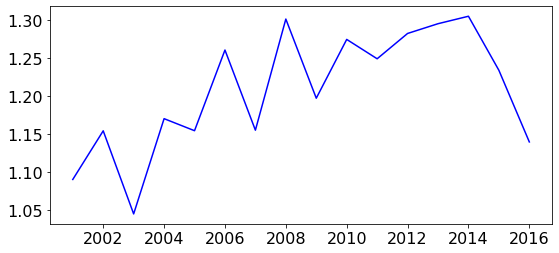

In [102]:
plt.figure(figsize = (9, 4))

plt.plot(np.arange(2001, 2017, 1), area_mean(MC_SO_an_bin_nan,y_range,x_range), c = 'blue')

In [167]:
# :MERRA-2 Precipitation:
# annual mean:

time_Array_training = times_Array_training
time_Array_predict = times_Array_predict

lats = y_range
lons = x_range

data_Array_actual_predict = predict_result_1r['LWP_actual_predict']
data_Array_actual_training = predict_result_1r['LWP_actual_training']
data_Array_predict_predict = predict_result_1r['LWP_predi_predict']
data_Array_predict_training = predict_result_1r['LWP_predi_training']


coef_dict = coef_obs
# print(coef_dict.shape)

output_CCF1 = area_mean(annually_mean(np.append(predict_result_1r['predict_Array']['SST'].reshape(dict_predict['LWP'].shape), predict_result_1r['training_Array']['SST'].reshape(dict_training['LWP'].shape), axis = 0), np.append(time_Array_predict, time_Array_training, axis = 0)), lats, lons)
output_CCF2 = area_mean(annually_mean(np.append(predict_result_1r['predict_Array']['p_e'].reshape(dict_predict['LWP'].shape), predict_result_1r['training_Array']['p_e'].reshape(dict_training['LWP'].shape), axis = 0), np.append(time_Array_predict, time_Array_training, axis = 0)), lats, lons)
# output_CCF2_IMERG3 = area_mean(annually_mean(np.append(predict_result_1r_IMERG3['predict_Array']['p_e_IMERG'].reshape(dict_predict_IMERG3['LWP'].shape), predict_result_1r_IMERG3['training_Array']['p_e_IMERG'].reshape(dict_training_IMERG3['LWP'].shape), axis = 0), np.append(times_Array_predict_IMERG3, times_Array_training_IMERG3, axis = 0)), lats, lons)
output_CCF2_IMERG3 = area_mean(MC_SO_an_bin_nan,y_range, x_range)

output_CCF3 = area_mean(annually_mean(np.append(predict_result_1r['predict_Array']['LTS'].reshape(dict_predict['LWP'].shape), predict_result_1r['training_Array']['LTS'].reshape(dict_training['LWP'].shape), axis = 0), np.append(time_Array_predict, time_Array_training, axis = 0)), lats, lons)
output_CCF4 = area_mean(annually_mean(np.append(predict_result_1r['predict_Array']['SUB'].reshape(dict_predict['LWP'].shape), predict_result_1r['training_Array']['SUB'].reshape(dict_training['LWP'].shape), axis = 0), np.append(time_Array_predict, time_Array_training, axis = 0)), lats, lons)

output_time = np.arange(0, time_Array_training.shape[0]//12 + time_Array_predict.shape[0]//12, 1)
output_time_IMERG3 = np.arange(0, times_Array_training_IMERG3.shape[0]//12 + times_Array_predict_IMERG3.shape[0]//12, 1) + 9

output_actual = area_mean(annually_mean(np.append(data_Array_actual_predict, data_Array_actual_training, axis = 0), times = np.append(time_Array_predict, time_Array_training, axis = 0)), lats, lons)
output_actual_IMERG3 = area_mean(annually_mean(np.append(predict_result_1r_IMERG3['LWP_actual_predict'], predict_result_1r_IMERG3['LWP_actual_training'], axis = 0), times = np.append(times_Array_predict_IMERG3, times_Array_training_IMERG3, axis = 0)), lats, lons)

# output_predict = area_mean(annually_mean(np.append(data_Array_predict_predict, data_Array_predict_training, axis = 0), times = np.append(time_Array_predict, time_Array_training, axis = 0)), lats, lons)
output_predict = (coef_obs[0][0] * output_CCF1[:] + coef_obs[1] + coef_obs[0][1] * output_CCF2 + coef_obs[0][2] * output_CCF3[:] + coef_obs[0][3] * output_CCF4[:])
output_predict_IMERG3 = (coef_obs[0][0] * output_CCF1[25-16:] + coef_obs[1] + coef_obs[0][1] * output_CCF2_IMERG3+ coef_obs[0][2] * output_CCF3[25-16:] + coef_obs[0][3] * output_CCF4[25-16:])

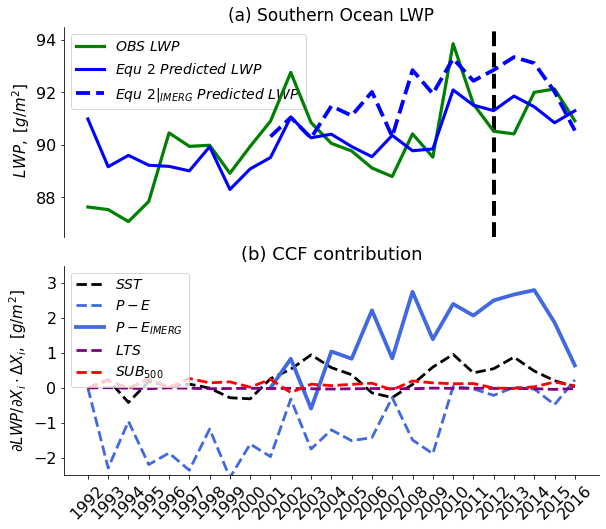

In [170]:
# Plotting_1:


parameters = {'axes.labelsize': 15, 'legend.fontsize': 14,
         'axes.titlesize': 18,  'xtick.labelsize': 16,  'ytick.labelsize': 16}
plt.rcParams.update(parameters)

fig = plt.figure( figsize = (9.6, 8.25))
gs = fig.add_gridspec(2, hspace = 0.137)
axs = gs.subplots(sharex=True, sharey= False)
axs[0].set_ylim(86.5, 94.5, 1.)
axs[1].set_ylim(-2.5, 3.5, 0.6)

# Hide the right and top spines:
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)

axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)

# Only show ticks on the left and bottom spines
axs[1].yaxis.set_ticks_position('left')
axs[1].xaxis.set_ticks_position('bottom')
axs[0].xaxis.set_ticks_position('none')

axs[0].plot(output_time, 1000.*output_actual, label = r'$OBS\ LWP$', alpha = 1.0, linewidth= 3.20, linestyle = '-', c = 'green', zorder = 98)
# axs[0].plot(output_time_IMERG3, 1000.*output_actual_IMERG3, label = r'$OBS\ LWP_{IMERG} $', alpha = 1.0, linewidth= 3.40, linestyle = '--', c = 'green', zorder = 98)

axs[0].plot(output_time, 1000.*output_predict, label = r'$Equ\ 2\ Predicted\ LWP$', alpha = 1.0, linewidth= 3.10, linestyle = '-', c = 'b', zorder = 98)
axs[0].plot(output_time_IMERG3, 1000.*output_predict_IMERG3, label = r'$Equ\ 2|_{IMERG} \ Predicted\ LWP$', alpha = 1.0, linewidth= 3.80, linestyle = '--', c = 'b', zorder = 98)

axs[0].axvline(time_Array_predict.shape[0]//12, linestyle = '--', linewidth = 4.0, c = 'k')

axs[1].plot(output_time, 1000.*((coef_dict[0][0] * output_CCF1 + coef_dict[1]) - (coef_dict[0][0] * output_CCF1[0] + coef_dict[1])), label = r'$SST$', alpha = 1.0, linewidth= 2.80, c = 'k', linestyle = '--')
axs[1].plot(output_time, 1000.*((coef_dict[0][1] * output_CCF2) - (coef_dict[0][1] * output_CCF2[0])), label = r'$P-E$', alpha = 1.0, linewidth= 2.80, c = 'royalblue', linestyle = '--')
axs[1].plot(output_time_IMERG3, 1000.*((coef_dict[0][1] * output_CCF2_IMERG3) - ((coef_dict[0][1] * output_CCF2_IMERG3[0]))), label = r'$P-E_{IMERG}$', alpha = 1.0, linewidth= 3.80, c = 'royalblue', linestyle = '-')
axs[1].plot(output_time, 1000.*((coef_dict[0][2] * output_CCF3) - (coef_dict[0][2] * output_CCF3[0])), label = r'$LTS$', alpha = 1.0, linewidth= 2.80, c = 'purple', linestyle = '--')
axs[1].plot(output_time, 1000.*((coef_dict[0][3] * output_CCF4) - (coef_dict[0][3] * output_CCF4[0])), label = r'$SUB_{500}$', alpha = 1.0, linewidth= 2.80, c = 'red', linestyle = '--')

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

axs[0].legend()
axs[1].legend(loc = 'upper left')
axs[0].set_ylim(86.5, 94.5, 1.)
# axs[1].set_ylim(0., 6., 0.6)
axs[1].set_xticks(output_time[0:])
axs[1].set_xticklabels((np.append(np.arange(time_Array_predict[0, 0], time_Array_predict[0, 0] + time_Array_predict.shape[0]//12, 1), np.arange(time_Array_training[0, 0], time_Array_training[0, 0] + time_Array_training.shape[0]//12, 1))).astype(int), rotation = 45)
# axs[0].set_xlabel(' Time ')
axs[0].set_ylabel(r"$\ LWP,\ $" + r"$ [g/m^{2}]$")  # kg*m^{-2} 
axs[1].set_ylabel(r"$\partial LWP/ \partial X_{i} \cdot \Delta X_{i},\ $" + r"$ [g/m^{2}]$")  #  std \cdot dev^{-1}
axs[0].set_title( "(a) Southern Ocean LWP", fontsize = 17)
axs[1].set_title( "(b) CCF contribution", fontsize = 18)
# fig.suptitle(" Observational trend of LWP from MAC-LWP ")

# plt.legend()
# plt.show()
# plt.savefig(path6 + 'Fig_4.jpg', bbox_inches = 'tight', dpi = 500)


In [173]:
#:IMERG3:Precipitation:
# annual mean:

time_Array_training = times_Array_training_IMERG3
time_Array_predict = times_Array_predict_IMERG3

lats = y_range
lons = x_range

data_Array_actual_predict = predict_result_1r_IMERG3['LWP_actual_predict']
data_Array_actual_training = predict_result_1r_IMERG3['LWP_actual_training']
data_Array_predict_predict = predict_result_1r_IMERG3['LWP_predi_predict']
data_Array_predict_training = predict_result_1r_IMERG3['LWP_predi_training']


# coef_dict = coef_obs
coef_dict = coef_obs_IMERG3
# print(coef_dict.shape)

output_CCF1 = area_mean(annually_mean(np.append(predict_result_1r_IMERG3['predict_Array']['SST'].reshape(dict_predict_IMERG3['LWP'].shape), predict_result_1r_IMERG3['training_Array']['SST'].reshape(dict_training_IMERG3['LWP'].shape), axis = 0), np.append(times_Array_predict_IMERG3, times_Array_training_IMERG3, axis = 0)), lats, lons)
output_CCF2 = area_mean(annually_mean(np.append(predict_result_1r_IMERG3['predict_Array']['p_e_IMERG'].reshape(dict_predict_IMERG3['LWP'].shape), predict_result_1r_IMERG3['training_Array']['p_e_IMERG'].reshape(dict_training_IMERG3['LWP'].shape), axis = 0), np.append(times_Array_predict_IMERG3, times_Array_training_IMERG3, axis = 0)), lats, lons)
output_CCF2_IMERG3 = area_mean(MC_SO_an_bin_nan,y_range, x_range)

output_CCF3 = area_mean(annually_mean(np.append(predict_result_1r_IMERG3['predict_Array']['LTS'].reshape(dict_predict_IMERG3['LWP'].shape), predict_result_1r_IMERG3['training_Array']['LTS'].reshape(dict_training_IMERG3['LWP'].shape), axis = 0), np.append(times_Array_predict_IMERG3, times_Array_training_IMERG3, axis = 0)), lats, lons)
output_CCF4 = area_mean(annually_mean(np.append(predict_result_1r_IMERG3['predict_Array']['SUB'].reshape(dict_predict_IMERG3['LWP'].shape), predict_result_1r_IMERG3['training_Array']['SUB'].reshape(dict_training_IMERG3['LWP'].shape), axis = 0), np.append(times_Array_predict_IMERG3, times_Array_training_IMERG3, axis = 0)), lats, lons)

# running_mean_window = 2
# output_CCF1 = df_CCF1.rolling((12* running_mean_window + 1), min_periods = 1, center = True).mean()
# output_CCF2 = df_CCF2.rolling((12* running_mean_window + 1), min_periods = 1, center = True).mean()
# output_CCF3 = df_CCF3.rolling((12* running_mean_window + 1), min_periods = 1, center = True).mean()
# output_CCF4 = df_CCF4.rolling((12* running_mean_window + 1), min_periods = 1, center = True).mean()
output_time = np.arange(0, time_Array_training.shape[0]//12 + time_Array_predict.shape[0]//12, 1)
output_actual = area_mean(annually_mean(np.append(data_Array_actual_predict, data_Array_actual_training, axis = 0), times = np.append(time_Array_predict, time_Array_training, axis = 0)), lats, lons)
output_predict = area_mean(annually_mean(np.append(data_Array_predict_predict, data_Array_predict_training, axis = 0), times = np.append(time_Array_predict, time_Array_training, axis = 0)), lats, lons)
output_predict_IMERG3 = (coef_dict[0][0] * output_CCF1 + coef_dict[1] + coef_dict[0][1] * output_CCF2_IMERG3+ coef_dict[0][2] * output_CCF3 + coef_dict[0][3] * output_CCF4)

/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/useful_func_cy.py:100: RuntimeWarning: Mean of empty slice
  annually_array[i,:,:] = nanmean(data[i*12:(i+1)*12, :,:], axis = 0)


Text(0.5, 1.0, '(b) CCF contribution')

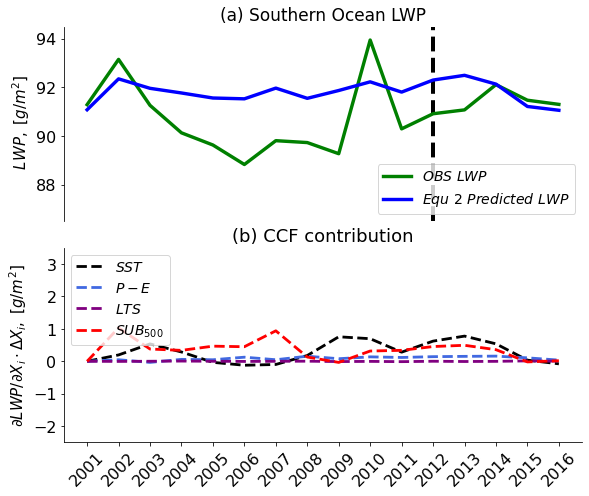

In [175]:
# Plotting_2:

parameters = {'axes.labelsize': 15, 'legend.fontsize': 14,
         'axes.titlesize': 18,  'xtick.labelsize': 16,  'ytick.labelsize': 16}
plt.rcParams.update(parameters)

fig = plt.figure( figsize = (9.3, 7.65))
gs = fig.add_gridspec(2, hspace = 0.137)
axs = gs.subplots(sharex=True, sharey= False)
axs[0].set_ylim(86.5, 94.5, 1.)
axs[1].set_ylim(-2.5, 3.5, 0.6)

# Hide the right and top spines:
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)

axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)

# Only show ticks on the left and bottom spines
axs[1].yaxis.set_ticks_position('left')
axs[1].xaxis.set_ticks_position('bottom')
axs[0].xaxis.set_ticks_position('none')

axs[0].plot(output_time, 1000.*output_actual, label = r'$OBS\ LWP$', alpha = 1.0, linewidth= 3.40, linestyle = '-', c = 'green', zorder = 98)
# axs[0].plot(output_time, 1000.*output_predict, label = r'$Equ\ 2\ Predicted\ LWP$', alpha = 1.0, linewidth= 3.40, linestyle = '-', c = 'b', zorder = 98)
axs[0].plot(output_time, 1000.*output_predict_IMERG3, label = r'$Equ\ 2\ Predicted\ LWP$', alpha = 1.0, linewidth= 3.40, linestyle = '-', c = 'b', zorder = 98)

axs[0].axvline(time_Array_predict.shape[0]//12, linestyle = '--', linewidth = 4.0, c = 'k')

axs[1].plot(output_time, 1000.*((coef_dict[0][0] * output_CCF1 + coef_dict[1]) - (coef_dict[0][0] * output_CCF1[0] + coef_dict[1])), label = r'$SST$', alpha = 1.0, linewidth= 2.80, c = 'k', linestyle = '--')
axs[1].plot(output_time, 1000.*((coef_dict[0][1] * output_CCF2_IMERG3) - (coef_dict[0][1] * output_CCF2_IMERG3[0])), label = r'$P-E$', alpha = 1.0, linewidth= 2.80, c = 'royalblue', linestyle = '--')
axs[1].plot(output_time, 1000.*((coef_dict[0][2] * output_CCF3) - (coef_dict[0][2] * output_CCF3[0])), label = r'$LTS$', alpha = 1.0, linewidth= 2.80, c = 'purple', linestyle = '--')
axs[1].plot(output_time, 1000.*((coef_dict[0][3] * output_CCF4) - (coef_dict[0][3] * output_CCF4[0])), label = r'$SUB_{500}$', alpha = 1.0, linewidth= 2.80, c = 'red', linestyle = '--')
# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

axs[0].legend()
axs[1].legend(loc = 'upper left')
axs[0].set_ylim(86.5, 94.5, 1.)
# axs[1].set_ylim(0., 6., 0.6)
axs[1].set_xticks(output_time[0:])
axs[1].set_xticklabels((np.append(np.arange(time_Array_predict[0, 0], time_Array_predict[0, 0] + time_Array_predict.shape[0]//12, 1), np.arange(time_Array_training[0, 0], time_Array_training[0, 0] + time_Array_training.shape[0]//12, 1))).astype(int), rotation = 45)
# axs[0].set_xlabel(' Time ')
axs[0].set_ylabel(r"$\ LWP,\ $" + r"$ [g/m^{2}]$")  # kg*m^{-2} 
axs[1].set_ylabel(r"$\partial LWP/ \partial X_{i} \cdot \Delta X_{i},\ $" + r"$ [g/m^{2}]$")  #  std \cdot dev^{-1}
axs[0].set_title( "(a) Southern Ocean LWP", fontsize = 17)
axs[1].set_title( "(b) CCF contribution", fontsize = 18)
# fig.suptitle(" Observational trend of LWP from MAC-LWP ")

# plt.legend()
# plt.show()
# plt.savefig(path6 + 'Fig_4(Supplem).jpg', bbox_inches = 'tight', dpi = 500)


34